In [1]:
import tensorflow as tf
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
from deepsphere import HealpyGCNN, healpy_layers as hp_layer
from healpy import read_map

data_directory = "/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/CMBFeatureNet/data/"
os.chdir(data_directory)
print("Current working directory:", os.getcwd())

2025-05-06 18:06:27.285062: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 18:06:30.778728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746547592.657822 3908034 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746547593.151204 3908034 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746547597.664117 3908034 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Current working directory: /mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/CMBFeatureNet/data


Filename: ./simulated_maps/lcdm/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   48R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
NSIDE: 64


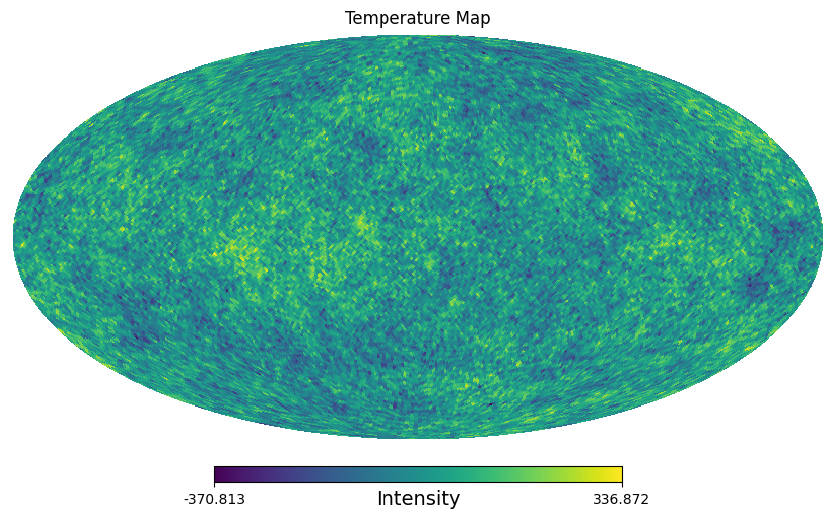

In [2]:
#Read the data
from CMBFeatureNet import read_map
path_lcdm = "./simulated_maps/lcdm/"
map_temp_data = read_map(path_lcdm + 'cmb_map_0.fits')

#Visualize the map
#nside = hp.npix2nside(len(map_temp_data))
nside = 64
print(f"NSIDE: {nside}")

#Plot
hp.mollview(map_temp_data, title="Temperature Map", unit="Intensity")
plt.show()

In [3]:
layers = [hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=2),
          tf.keras.layers.Lambda(lambda x: tf.nn.softmax(tf.reduce_mean(x, axis=1),
                                                         axis=-1))]

In [4]:
indices = np.arange(hp.nside2npix(nside))

In [5]:
tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
batch_size = 16
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

25-05-06 18:07:58  sbi_flows INF   WARNING: This network assumes that everything concerning healpy is in NEST ordering... 
25-05-06 18:07:58  sbi_flows INF   Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices... 
25-05-06 18:07:58  sbi_flows INF   indices seem consistent... 


2025-05-06 18:08:11.003386: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "healpy_gcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ chebyshev (Chebyshev)                          │ (None, 49152, 5)                    │                  65 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool (HealpyPool)                       │ (None, 12288, 5)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_1 (Chebyshev)                        │ (None, 12288, 5)                    │                 265 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool_1 (HealpyPool)                     │ (None, 3072, 5)                     │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_2 (Chebyshev)                        │ (None, 3072, 5)                     │                 265 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool_2 (HealpyPool)                     │ (None, 768, 5)                      │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_3 (Chebyshev)                        │ (None, 768, 2)                      │                 100 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ lambda (Lambda)                                │ (None, 2)                           │                   0 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 695 (2.71 KB)

 Trainable params: 665 (2.60 KB)

 Non-trainable params: 30 (120.00 B)

In [6]:
def read_all_maps(path_lcdm, path_feature, n_maps=100):
    maps = []
    labels = []
    
    # Read LCDM maps
    for i in range(n_maps):
        map_lcdm = read_map(f"{path_lcdm}cmb_map_{i}.fits")
        maps.append(map_lcdm)
        labels.append(0)  #lcdm
    
    # Read feature maps
    for i in range(n_maps):
        map_feature = read_map(f"{path_feature}cmb_map_feature_{i}.fits")
        maps.append(map_feature)
        labels.append(1)  #feature
    
    maps = np.array(maps).astype(np.float32)[..., None]  #Add channel dimension
    labels = np.array(labels).astype(np.int32)
    #print(labels)
    return maps, labels

In [7]:
path_feature = "./simulated_maps/feature/"
x_raw, y_raw = read_all_maps(path_lcdm, path_feature, n_maps=12)

Filename: ./simulated_maps/lcdm/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   48R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   48R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   48R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU    

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [10]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(x_test, y_test),
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.6011 - sparse_categorical_accuracy: 0.4167 - val_loss: 53.2718 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step - loss: 1.7428 - sparse_categorical_accuracy: 0.5833 - val_loss: 173.5485 - val_sparse_categorical_accuracy: 0.3750
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - loss: 1.4832 - sparse_categorical_accuracy: 0.5833 - val_loss: 259.8946 - val_sparse_categorical_accuracy: 0.3750
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - loss: 1.2332 - sparse_categorical_accuracy: 0.5833 - val_loss: 256.6260 - val_sparse_categorical_accuracy: 0.3750
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - loss: 0.9300 - sparse_categorical_accuracy: 0.5833 - val_loss: 213.3062 - val_sparse_categorical_accuracy: 0.3750
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step - loss: 0.7239 - sparse_categorical_accuracy: 0.5833 - val_loss: 168.9678 - val_sparse_categorical_accuracy: 0.3750
Epoch 7/